<a href="https://colab.research.google.com/github/alxkzncoff/skillfactory_rds6_car_price_prediction_ml_dl/blob/main/model/cat_boost_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INSTALL

In [1]:
!pip install catboost
!pip install PyDrive
!mkdir work_dir

     |████████████████████████████████| 66.2MB 57kB/s 


# DEFINE

In [9]:
# DEFINE
DATA_PATH                   = '/content/work_dir'
RANDOM_SEED                 = 42

# IMPORT

In [150]:
# Data access
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)

# ML
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostRegressor
from catboost import Pool
from catboost import cv
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [6]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [10]:
# Download clear_train.csv from google drive to Colab VM.
downloaded = drive.CreateFile({'id':"1-3kiZxEddvuNFoRTfMA6cA8bu7LjP2b3"}) # откуда берем файл
downloaded.GetContentFile(DATA_PATH+'/clear_train.csv') # куда сохраняем файл в вирутальной машине колаба

# Download clear_test.csv from google drive to Colab VM.
downloaded = drive.CreateFile({'id':"1-0yG59TcpJoDSeOclid1z-nc1Fh3yud2"})
downloaded.GetContentFile(DATA_PATH+'/clear_test.csv')

# Download sample_submission from google drive to Colab VM.
downloaded = drive.CreateFile({'id':"1Edwuioev6uEyeXuCQuloPNQ70V5-3HZG"})
downloaded.GetContentFile(DATA_PATH+'/sample_submission.csv')

In [57]:
train = pd.read_csv(DATA_PATH+'/clear_train.csv')
test = pd.read_csv(DATA_PATH+'/clear_test.csv')
sample_submission = pd.read_csv(DATA_PATH+'/sample_submission.csv')

In [58]:
train.num_of_doors = train.num_of_doors.astype(str)
test.num_of_doors = test.num_of_doors.astype(str)

In [59]:
display(train.info())
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   body                 6682 non-null   object 
 1   brand                6682 non-null   object 
 2   color                6682 non-null   object 
 3   description          6682 non-null   object 
 4   engine_displacement  6682 non-null   float64
 5   engine_power         6682 non-null   float64
 6   fuel                 6682 non-null   object 
 7   mileage              6682 non-null   int64  
 8   model_date           6682 non-null   int64  
 9   model_info           6682 non-null   object 
 10  name                 6682 non-null   object 
 11  num_of_doors         6682 non-null   object 
 12  price                6682 non-null   float64
 13  production_date      6682 non-null   int64  
 14  sell_id              6682 non-null   int64  
 15  transmission         6682 non-null   o

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   body                 1671 non-null   object 
 1   brand                1671 non-null   object 
 2   color                1671 non-null   object 
 3   description          1671 non-null   object 
 4   engine_displacement  1671 non-null   float64
 5   engine_power         1671 non-null   float64
 6   fuel                 1671 non-null   object 
 7   mileage              1671 non-null   int64  
 8   model_date           1671 non-null   int64  
 9   model_info           1671 non-null   object 
 10  name                 1671 non-null   object 
 11  num_of_doors         1671 non-null   object 
 12  production_date      1671 non-null   int64  
 13  sell_id              1671 non-null   int64  
 14  transmission         1671 non-null   object 
 15  owners               1671 non-null   o

None

# DATA PREPARING

In [60]:
df = pd.concat([train, test])

In [61]:
df.price.fillna(0, inplace=True)
df['sample'] = df.price.apply(lambda x:0 if x == 0 else 1)

In [62]:
# # ##################### Логорифмируем ######################
df.engine_displacement = df.engine_displacement.max() - np.log(df.engine_displacement)
df.engine_power = df.engine_power.max() - np.log(df.engine_power)

In [63]:
def data_prep(df):

  categorical_features = ['body', 'brand', 'color', 'fuel', 'model_info', 'name',  'num_of_doors',  'transmission', 'owners', 'vehicle_title', 'drive_type']
  numerical_features = ['engine_displacement', 'engine_power', 'mileage', 'model_date', 'production_date', 'tax', 'days_in_use']

  # ############################### Normalization ######################################
  MMS = MinMaxScaler()

  MMS.fit(df[numerical_features])
  df[numerical_features] = MMS.transform(df[numerical_features])

  return df, categorical_features 

In [64]:
df, cat_features = data_prep(df)
df.shape

(8353, 22)

In [103]:
# Узнаем количество уникальных значений для каждого категориального признака.
# Это нужно для параметра one_hot_max_size, при построении модели
cat_unique_df = pd.DataFrame(columns=['unique_values'], index=[cat_features])

for column in df[cat_features]:
  cat_unique_df.at[column, 'unique_values'] = df[column].nunique()

cat_unique_df

,unique_values
body,13
brand,3
color,16
fuel,4
model_info,122
name,360
num_of_doors,4
transmission,4
owners,4
vehicle_title,2


# SPLIT

In [65]:
X = df.query('sample==1').drop(columns=['description', 'price', 'sample', 'sell_id'])
y = df.query('sample==1').price.values
test = df.query('sample==0').drop(columns=['description', 'price', 'sample', 'sell_id'])

# ############ Split #################
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
# gsctb = CatBoostRegressor()

# params_grid = {'iterations':[1500, 2000, 4000, 5500],
#                'learning_rate':[0.5, 0.1, 0.05, 0.03, 0.005],
#                'l2_leaf_reg':[1, 2, 4, 6, 8],
#                'bootstrap_type': ['Bayesian','Bernoulli']}

# grid_search_result = gsctb.grid_search(params_grid,
#                                      train_data,
#                                      cv=5,
#                                      partition_random_seed=RANDOM_SEED,
#                                      calc_cv_statistics=True,
#                                      search_by_train_test_split=True,
#                                      refit=True,
#                                      shuffle=True,
#                                      train_size=0.8,
#                                      verbose=500,
#                                      plot=True)

In [66]:
train_data = Pool(data = X_train,
                  label = y_train,
                  cat_features =  cat_features)

test_data = Pool(data = X_test,
                 label = y_test,
                  cat_features =  cat_features)

# MODEL

In [157]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [115]:
ctb = CatBoostRegressor( loss_function = 'MAE',
                         eval_metric = 'MAPE',
                         learning_rate=0.002,
                         iterations=25000, # обучаем до overfitting'a
                         l2_leaf_reg=2,
                         depth=5,
                         bootstrap_type = 'Bernoulli', # Bayesian Bernoulli
                         one_hot_max_size = 360,
                         random_seed=RANDOM_SEED,
                         od_type='Iter',
                         od_wait=500,
                         task_type='CPU')


model = ctb.fit(train_data,
                eval_set=test_data,
                verbose_eval=500,
                use_best_model=True)
#                plot=True)
print(model)

test_predict_cat = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_cat))*100:0.2f}%")

0:	learn: 0.6290641	test: 0.6430628	best: 0.6430628 (0)	total: 2.95ms	remaining: 1m 13s
500:	learn: 0.3209311	test: 0.3249708	best: 0.3249708 (500)	total: 1.33s	remaining: 1m 5s
1000:	learn: 0.2134205	test: 0.2138003	best: 0.2138003 (1000)	total: 2.62s	remaining: 1m 2s
1500:	learn: 0.1731648	test: 0.1728946	best: 0.1728946 (1500)	total: 3.9s	remaining: 1m 1s
2000:	learn: 0.1561105	test: 0.1554015	best: 0.1554015 (2000)	total: 5.16s	remaining: 59.3s
2500:	learn: 0.1470962	test: 0.1457395	best: 0.1457395 (2500)	total: 6.42s	remaining: 57.8s
3000:	learn: 0.1412335	test: 0.1396105	best: 0.1396105 (3000)	total: 7.69s	remaining: 56.3s
3500:	learn: 0.1368790	test: 0.1348112	best: 0.1348112 (3500)	total: 8.94s	remaining: 54.9s
4000:	learn: 0.1337240	test: 0.1317239	best: 0.1317239 (4000)	total: 10.2s	remaining: 53.6s
4500:	learn: 0.1307827	test: 0.1290613	best: 0.1290613 (4500)	total: 11.5s	remaining: 52.3s
5000:	learn: 0.1282293	test: 0.1268744	best: 0.1268744 (5000)	total: 12.8s	remaining: 5

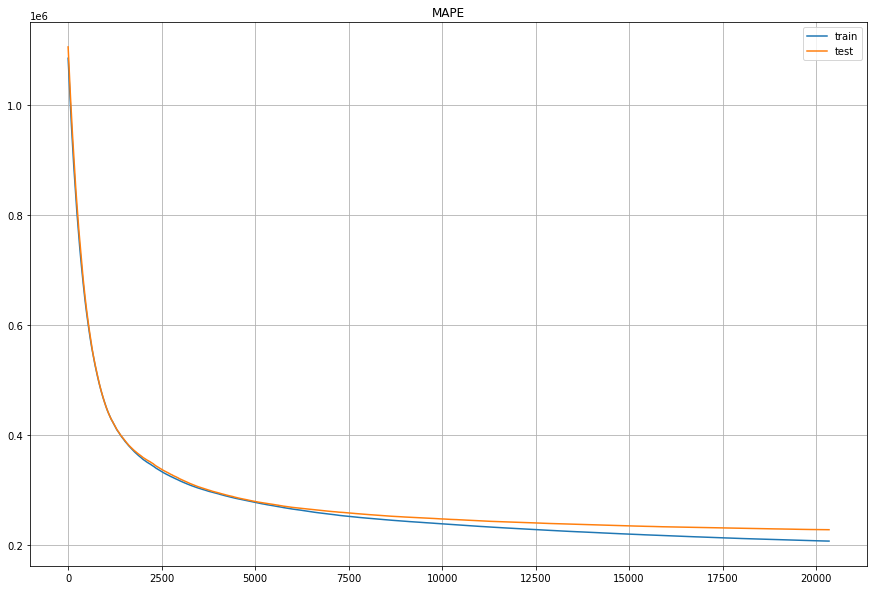

In [149]:
plt.figure(figsize=(15,10))
plt.title('MAPE')
plt.plot(model.evals_result_['learn']['MAE'], label='train')
plt.plot(model.evals_result_['validation']['MAE'], label='test')
plt.legend()
plt.grid()
plt.show()

# PREDICTION

In [127]:
predict_data = Pool(data = test,
                    cat_features =  cat_features)

predict_submission = model.predict(predict_data)

# MAKE SUBMISSION


In [129]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(DATA_PATH+f'/sub_cat_{round((mape(y_test, test_predict_cat)*100),2)}.csv'.replace('.', '_', 1), index=False)
display(sample_submission.head(10))

,sell_id,price
0,1099427284,5.593298e+05
1,1096405886,2.622844e+06
2,1100195294,6.487938e+05
3,1099827282,4.710850e+05
4,1100076198,2.640428e+06
5,1090159352,3.120887e+06
6,1098987386,1.586746e+06
7,1098639040,1.131575e+06
8,1099933039,1.062284e+06
9,1099565572,5.000182e+05


# CROSS_VALIDATION

In [151]:
def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor( loss_function = 'MAE',
                         eval_metric = 'MAPE',
                         learning_rate=0.002,
                         iterations=25000, # обучаем до overfitting'a
                         l2_leaf_reg=2,
                         depth=5,
                         bootstrap_type = 'Bernoulli', # Bayesian Bernoulli
                         one_hot_max_size = 360,
                         random_seed=RANDOM_SEED,
                         od_type='Iter',
                         od_wait=500,
                         task_type='CPU')

    model.fit(X_train, y_train,
              cat_features = cat_features,
              eval_set=(X_test, y_test),
              verbose_eval=False,
              use_best_model=True,
              plot=False)
    
    return(model)

In [154]:
cv_submissions = pd.DataFrame(0,columns=["sub_1"], index=sample_submission.index)
score_ls = []
splits = list(KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED).split(X, y))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=10,):

    X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]

    model = cat_model(y_train, X_train, X_test, y_test,)

    test_predict_cat_cv = model.predict(X_test)
    test_score = mape(y_test, test_predict_cat_cv)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(y_test, test_predict_cat_cv):0.3f}")

    cv_submissions[f'sub_{idx+1}'] = model.predict(predict_data)
    model.save_model(f'catboost_fold_{idx+1}.model')
    
print(f'Mean Score: {np.mean(score_ls):0.3f}')
print(f'Std Score: {np.std(score_ls):0.4f}')
print(f'Max Score: {np.max(score_ls):0.3f}')
print(f'Min Score: {np.min(score_ls):0.3f}')

1 Fold Test MAPE: 0.110
2 Fold Test MAPE: 0.116
3 Fold Test MAPE: 0.122
4 Fold Test MAPE: 0.111
5 Fold Test MAPE: 0.116
6 Fold Test MAPE: 0.116
7 Fold Test MAPE: 0.116
8 Fold Test MAPE: 0.124
9 Fold Test MAPE: 0.118
10 Fold Test MAPE: 0.113

Mean Score: 0.116
Std Score: 0.0042
Max Score: 0.124
Min Score: 0.110


In [155]:
cv_submissions.head(10)

,sub_1,sub_2,sub_3,sub_4,sub_5,sub_6,sub_7,sub_8,sub_9,sub_10
0,5.433590e+05,6.682696e+05,6.654378e+05,6.008724e+05,6.051422e+05,6.079627e+05,6.108982e+05,6.203338e+05,6.181714e+05,5.870106e+05
1,2.589885e+06,2.666680e+06,2.629554e+06,2.694092e+06,2.626366e+06,2.624242e+06,2.632663e+06,2.681922e+06,2.734216e+06,2.683710e+06
2,6.492972e+05,6.539836e+05,6.452942e+05,6.443631e+05,6.449268e+05,6.538890e+05,6.471207e+05,6.488200e+05,6.458497e+05,6.509623e+05
3,4.702253e+05,4.837059e+05,4.808036e+05,4.806267e+05,4.864937e+05,4.656737e+05,4.737458e+05,4.785433e+05,4.755608e+05,4.756869e+05
4,2.643594e+06,2.662310e+06,2.634423e+06,2.677798e+06,2.655091e+06,2.623377e+06,2.659149e+06,2.660140e+06,2.624911e+06,2.644252e+06
5,3.135606e+06,3.161623e+06,3.197013e+06,3.165529e+06,3.168977e+06,3.163585e+06,3.187748e+06,3.174781e+06,3.199831e+06,3.122172e+06
6,1.585772e+06,1.580914e+06,1.583452e+06,1.567527e+06,1.581591e+06,1.579723e+06,1.584517e+06,1.588745e+06,1.575816e+06,1.582892e+06
7,1.130641e+06,1.155412e+06,1.151078e+06,1.167025e+06,1.179572e+06,1.126332e+06,1.176027e+06,1.099274e+06,1.131712e+06,1.141261e+06
8,1.071642e+06,1.069483e+06,1.075131e+06,1.074740e+06,1.068171e+06,1.082646e+06,1.063779e+06,1.057474e+06,1.076195e+06,1.063919e+06
9,5.008603e+05,5.161245e+05,5.231730e+05,5.105087e+05,5.124644e+05,5.107866e+05,5.191320e+05,5.094915e+05,5.172248e+05,5.098484e+05


In [156]:
sample_submission['price'] = (cv_submissions.sum(axis=1)/len(cv_submissions.columns))
sample_submission.to_csv(DATA_PATH+'/sub_cat_cv.csv', index=False)
display(sample_submission.head(10))

,sell_id,price
0,1099427284,6.127458e+05
1,1096405886,2.656333e+06
2,1100195294,6.484507e+05
3,1099827282,4.771066e+05
4,1100076198,2.648505e+06
5,1090159352,3.167686e+06
6,1098987386,1.581095e+06
7,1098639040,1.145834e+06
8,1099933039,1.070318e+06
9,1099565572,5.129614e+05
